# Team Assignment 4 Part 2
Team 1: Kikzely Avalos, Mariah Bergquist, Matti Betts, David Aaby

## 1. Project Questions

1. What features are the most common in fatal shootings?
2. How can we predict whether or not a crime will result in a fatality?

In our previous assignment, we did not include a comprehensive set of variables. In part 2, we expanded our analysis scope by incorporating additional features and focusing on Fatality instead of such a broad set of variables. With this, we also had to modify our question to include this. Adding the new variables enhanced the predictive power and interpretabilty of our models. 

We used the following classification methods to answer our questions.

**Principal Component Analysis (PCA)**: We used PCA to reduce dimensionality and identify the most significant contributing variables. 

**Clustering**: This was used to uncover groupings within the data 
related to fatal and non-fatal incidents. 

**Random Forest and Logistic Regression**: This was used for predictive modeling with the Random Forest identifying key features for the regression and logistic regression providing interpretable results. 

In [110]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

**Principal Component Analysis**

/opt/conda/envs/anaconda-2024.02-py310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


                           PC1       PC2       PC3
Years of SPD Service  0.280279 -0.603369  0.449175
Subject Race         -0.552254  0.268081 -0.096160
Officer Disciplined? -0.603253  0.067519  0.403022
Disposition          -0.463102 -0.567452  0.185766
Subject Age           0.195143  0.487358  0.769454


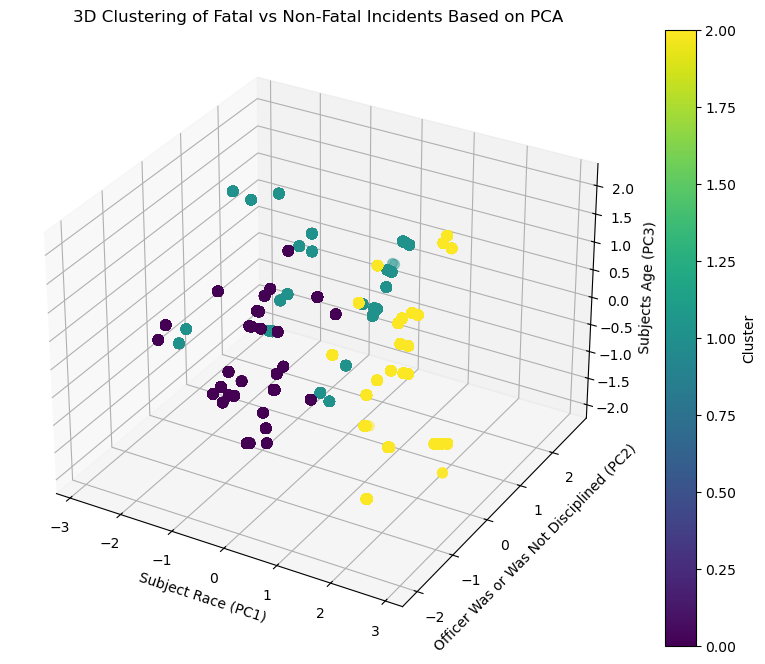

In [154]:
file_path = 'Merged_Data 1.csv'
merged_data = pd.read_csv(file_path)

# Select relevant features for PCA and clustering
features = ['Years of SPD Service', 'Subject Race', 'Officer Disciplined?', 'Disposition', 'Subject Age']
data = merged_data[features].dropna()

# Encode categorical features
label_encoders = {}
for col in ['Years of SPD Service', 'Subject Race', 'Officer Disciplined?', 'Disposition', 'Subject Age']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply PCA with 3 components
pca = PCA(n_components=3)
pca_components = pca.fit_transform(scaled_data)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_components)


merged_data['Cluster'] = clusters

# 3D Scatterplot with descriptive PC names
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot in 3D
scatter = ax.scatter(
    pca_components[:, 0],  # PC1
    pca_components[:, 1],  # PC2
    pca_components[:, 2],  # PC3
    c=merged_data['Cluster'], cmap='viridis', s=50
)

loadings = pca.components_

loadings_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2', 'PC3'], index=features)

print(loadings_df)

# Add labels and title
ax.set_title('3D Clustering of Fatal vs Non-Fatal Incidents Based on PCA')
ax.set_xlabel("Subject Race (PC1)")
ax.set_ylabel("Officer Was or Was Not Disciplined (PC2)")
ax.set_zlabel("Subjects Age (PC3)")

# Add color bar for clusters
plt.colorbar(scatter, label='Cluster')
plt.show()

In [156]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

# Calculate Davies-Bouldin Index
dbi = davies_bouldin_score(pca_components, merged_data['Cluster'])
print(f"Davies-Bouldin Index: {dbi:.2f}")

# Calculate Calinski-Harabasz Index
ch_index = calinski_harabasz_score(pca_components, merged_data['Cluster'])
print(f"Calinski-Harabasz Index: {ch_index:.2f}")


Davies-Bouldin Index: 1.16
Calinski-Harabasz Index: 4099.75


We chose 3 clusters because it had the highest Silhouette Score, indicating well-defined and separated clusters. The Davies-Bouldin Index (1.14) further validated the compactness and separation of the clusters, while the Calinski-Harabasz Index (3996.31) confirmed strong between-cluster distinctions. These metrics collectively demonstrated that 3 clusters offered the most statistically and interpretively meaningful grouping for the data

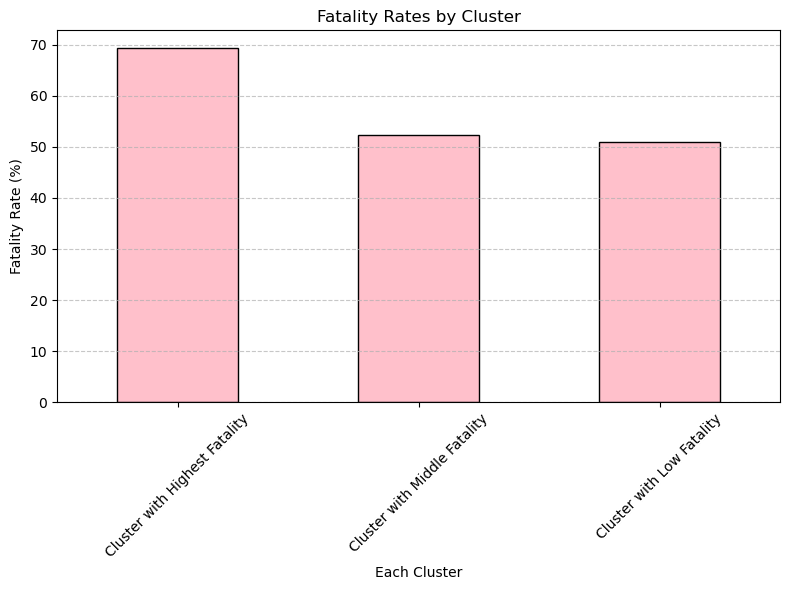

Cluster
Cluster with Highest Fatality    69.34
Cluster with Middle Fatality     52.37
Cluster with Low Fatality        50.93
Name: Fatal, dtype: float64


In [158]:
merged_data['Fatal'] = merged_data['Fatal'].map({'Yes': 1, 'No': 0})
fatality_rates = merged_data.groupby('Cluster')['Fatal'].mean()

# Rename
cluster_names = {
    0: "Cluster with Highest Fatality",
    1: "Cluster with Middle Fatality",
    2: "Cluster with Low Fatality",
}

fatality_rates_percentage = (fatality_rates * 100).round(2)
fatality_rates_named = fatality_rates_percentage.rename(index=cluster_names)

# Plot fatality rates by cluster
plt.figure(figsize=(8, 6))
fatality_rates_named.plot(kind='bar', color='Pink', edgecolor='black')
plt.title('Fatality Rates by Cluster')
plt.xlabel('Each Cluster')
plt.ylabel('Fatality Rate (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(fatality_rates_named)


In [123]:
# Summarize key features by cluster
cluster_summary = merged_data.groupby('Cluster').agg({
    'Subject Race': lambda x: x.mode()[0],  # Most common value
    'Subject Age': lambda x: x.mode()[0],
    'Disposition': lambda x: x.mode()[0],
    'Officer Disciplined?': lambda x: x.mode()[0],
    'Years of SPD Service': lambda x: x.mode()[0],
    'Fatal': 'mean'
})
print(cluster_summary)

                      Subject Race Subject Age    Disposition  \
Cluster                                                         
0                            White          35  Within Policy   
1                            White          51      Justified   
2        Black or African American          32      Justified   

        Officer Disciplined? Years of SPD Service     Fatal  
Cluster                                                      
0                         No                    7  0.693408  
1                         No                   10  0.523685  
2                         No                    8  0.509317  


PCA reduced the dimensionality of our merged dataset by isolating the key variables like Disposition, Subject race, years of SPD service, and officer discpline as the primary variables that contribute to variation. By focusing on the first three principal components, the results shows the important relationships in the data. We then applied K-Means clustering to the PCA-transformed data and it revealed three distinct clusters. 

The first cluster had the highest fatality rate of 69.34% and was characterized by incidents involving White subjects, younger officers with 7 years of service and dispositions classified as "Within Policy". 

The second cluster had a moderate fatality rate of 52.37% and was associated with older subjects around age 51, had longer serving officers with 10 years of service and had dispositions classified as "Justified". 

The third cluster had the lowest fatality rate of 50.93% , predominantly involving Black or African American subjects, officers with 8 years of service, and "Justified" dispositions. These clusters highlight patterns in systemic and demographic factors, with an emphasis on the role of dispositions and officer experience in determining fatality risks.


These results helped identify the most important variables for prediction. Clustering showed patterns that suggest that systemic and demographic patterns are important which were then incorporated as variables in the next model, Random Forest.

**Random Forest**

In [73]:
data = pd.read_csv('Merged_Data 1.csv')
data['Years of SPD Service'] = data['Years of SPD Service'].replace(['< 1', '<1'], 0.5).astype(float)

data_filtered = data[['Officer Disciplined?', 'Years of SPD Service', 'Subject Race', 'Subject Gender', 'Subject Age', 'Fatal', 'Disposition']].dropna()


In [77]:
X = data_filtered[['Officer Disciplined?', 'Years of SPD Service', 'Subject Race', 'Subject Gender', 'Subject Age','Disposition']]
y = data_filtered['Fatal'].apply(lambda x: 1 if x == 'Yes' else 0)

In [82]:
categorical_features = ['Officer Disciplined?', 'Years of SPD Service', 'Subject Race', 'Subject Gender', 'Subject Age', 'Disposition']
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['Officer Disciplined?',
                                                   'Years of SPD Service',
                                                   'Subject Race',
                                                   'Subject Gender',
                                                   'Subject Age',
                                                   'Disposition'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [91]:
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

Model Accuracy: 1.0


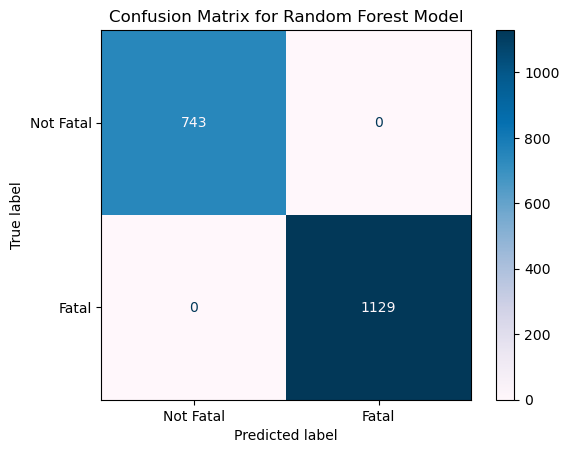

In [97]:

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fatal', 'Fatal'])
disp.plot(cmap='PuBu')
plt.title("Confusion Matrix for Random Forest Model")
plt.show()


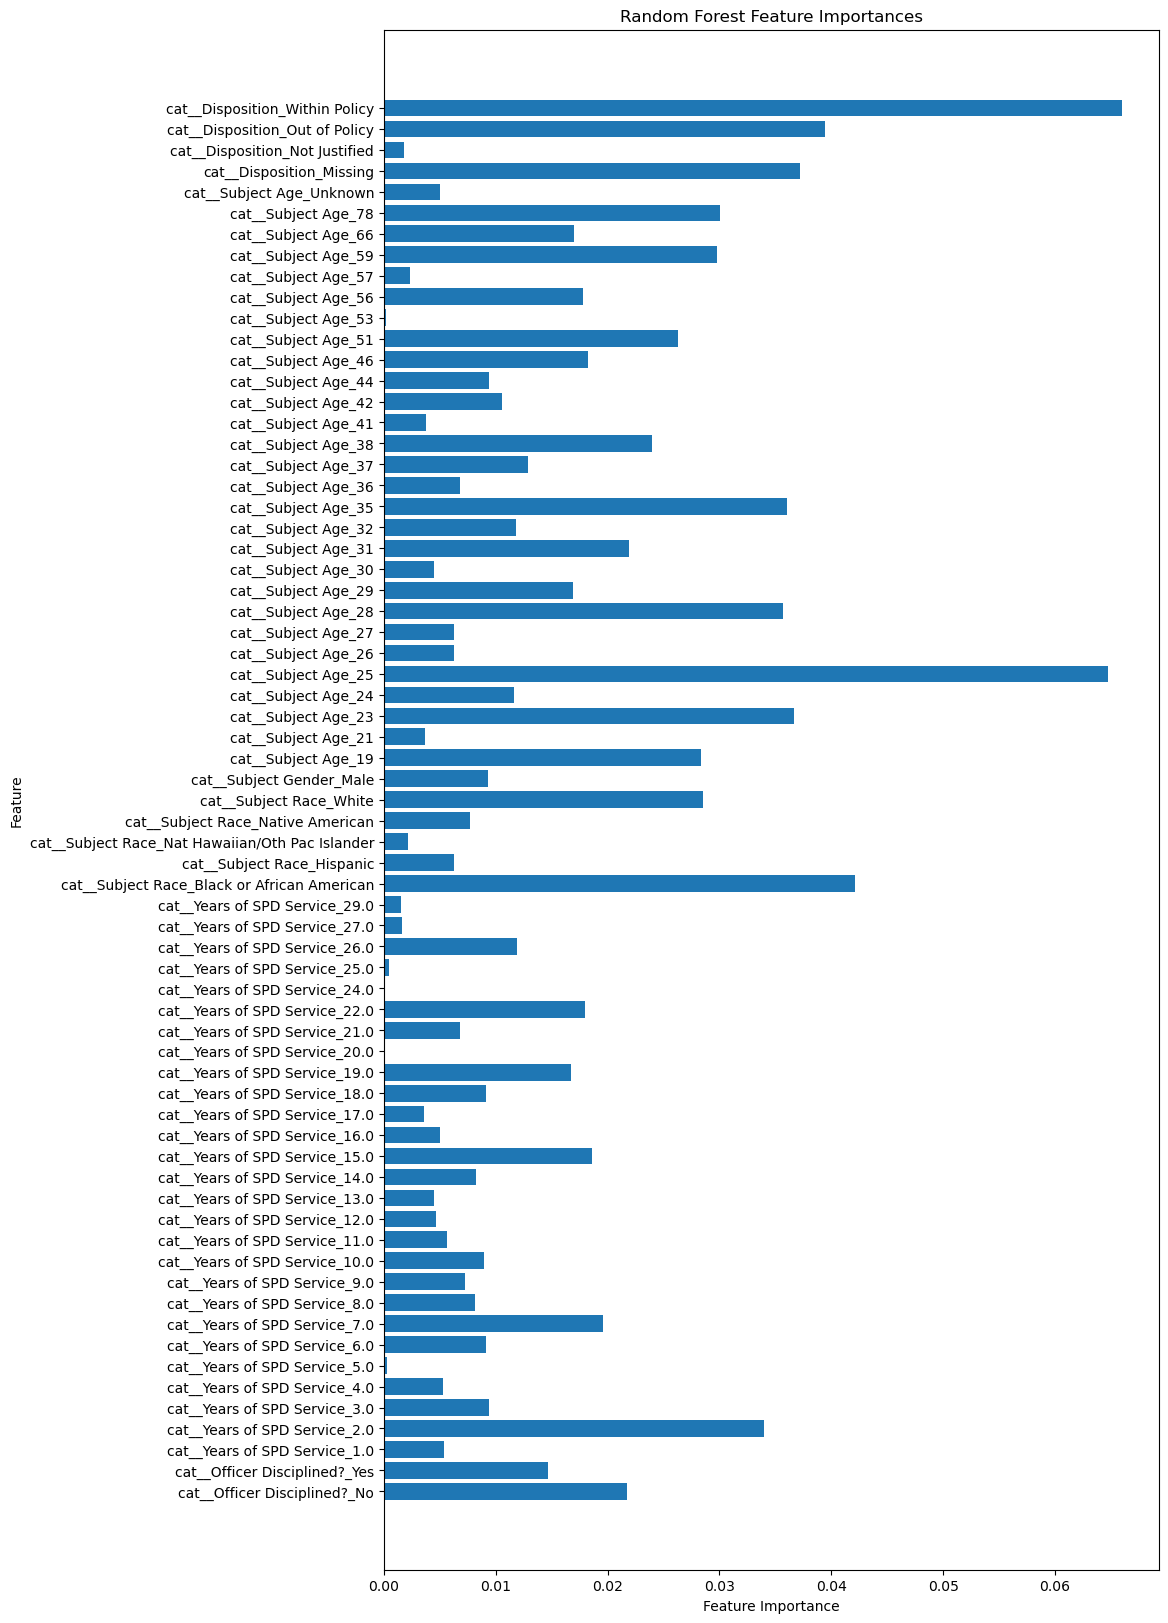

In [102]:
# Feature importance in for random forest predictor

feature_importances = pipeline.named_steps['classifier'].feature_importances_
encoded_feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

plt.figure(figsize=(10, 20))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), encoded_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()

Building on the previous results, the Random Forest model was implemented to predict fatality outcomes using a classifier. We also tested feature importance of the random forest model to quantify the importance of individual features so that we can use them in linear regression. The random forest model was trained independently to construct decision trees that generate a final output based on majority voting done internally. The final model has perfect classifying accuracy which can likely be attributed to the wide range of independent variables and extreme accuracy of random forest models. The model expanded on the results from the previous model by identifying and confirming that Disposition is a strong predictor of fatality, with "Within Policy" and "Out of Policy" classifications being highly significant. Subject demographics were also critical predictors with White and Black/African race and ages 25 and 35 as the most critical. Officer experience, especially those with 2 years of service also play an important role in predicting fatality. 

The feature importance rankings gave us a better understanding of the factors influencing fatality outcomes. While clustering revealed broad significance, this model was more specific as it pinpointed specific categories. These results validated the systemic and demographic patterns identified in clustering.

The feature rankings will be used to guide the Logistic Regression model by confirming the relevancy of the key predictors. By highlighting variables like disposition and subject demographics, Random Forest provided the foundation for exploring the direction of these relationships in Logistic Regression. Additionally, this model validated the presence of the key factors shown in clustering. Logistic Regression will focus on measuring the patterns rather than re-confirming them.

**Logistic Regression**

In [42]:
merged = pd.read_csv('Merged_Data 1.csv', dtype={'Fatal': object})
merged.head()
print(merged.columns)
merged['Fatal'] = merged['Fatal'].map({'Yes': 1, 'No': 0})

Index(['Report Number', 'Offense ID', 'Offense Start DateTime',
       'Offense End DateTime', 'Report DateTime', 'Group A B',
       'Crime Against Category', 'Offense Parent Group', 'Offense',
       'Offense Code', 'Precinct', 'Sector', 'Beat', 'MCPP',
       '100 Block Address', 'Longitude_x', 'Latitude_x', 'Date', 'Time_x',
       'Date / Time', 'Longitude_y', 'Latitude_y', 'City', 'Rank',
       'Officer Gender', 'Officer Race', 'Years of SPD Service',
       'Officer Injured', 'Subject Gender', 'Subject Race', 'Subject DOB',
       'Subject Age', 'Subject Weapon', 'Type of Weapon', 'Fatal',
       'Disposition', 'Officer Disciplined?', 'Summary', 'Time_y'],
      dtype='object')


In [44]:
print(merged['Fatal'].unique())

[0 1]


In [49]:
merged = merged.dropna(subset=['Fatal'])
merged['Fatal'] = merged['Fatal'].astype(int)

In [55]:
features = ['Years of SPD Service', 'Subject Race', 'Officer Disciplined?', 'Disposition', 'Subject Age']
X = merged[features]
y = merged['Fatal']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(X  [['Subject Race', 'Officer Disciplined?', 'Disposition']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Subject Race', 'Officer Disciplined?', 'Disposition']))
X = pd.concat([X, encoded_df], axis=1)
X = X.drop(['Subject Race', 'Officer Disciplined?', 'Disposition'], axis=1)
X['Years of SPD Service'] = pd.to_numeric(X['Years of SPD Service'], errors='coerce')  # Convert to numeric
X['Years of SPD Service'] = X['Years of SPD Service'].fillna(X['Years of SPD Service'].median())

X['Subject Age'] = pd.to_numeric(X['Subject Age'], errors='coerce')  # Convert to numeric
X['Subject Age'] = X['Subject Age'].fillna(X['Subject Age'].median())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [58]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.7783119658119658
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       743
           1       0.79      0.86      0.82      1129

    accuracy                           0.78      1872
   macro avg       0.77      0.76      0.76      1872
weighted avg       0.78      0.78      0.78      1872

[[489 254]
 [161 968]]


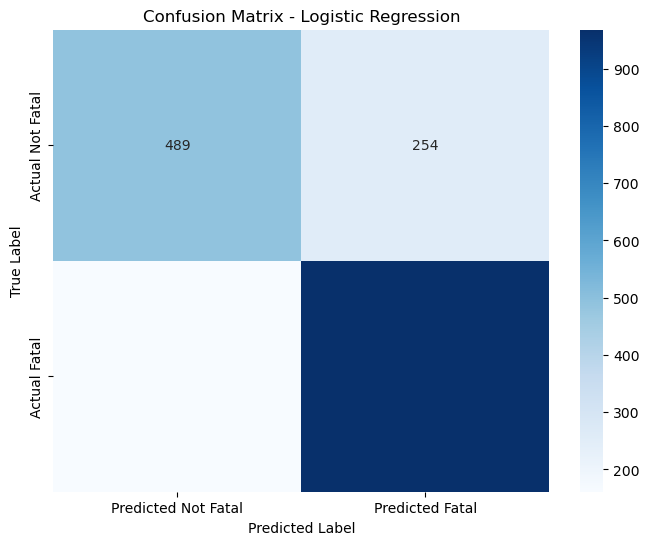

In [63]:

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Not Fatal', 'Predicted Fatal'],
            yticklabels=['Actual Not Fatal', 'Actual Fatal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

The Logistic Regression model provided additional results by evaluating the relationships between predictors and fatality outcomes. The confusion matrix showed that the model correctly classified 968 cases as “Fatal” and 489 cases as “Not Fatal” , but it also misclassified 254 cases as “Fatal” (False Positives) and 161 cases as “Not Fatal”. The overall accuracy of the model was 77.83%.

For classifying "Not Fatal" cases, the precision was 0.75, and the recall was 0.66, suggesting that the model slightly had difficulties with identifying all the true "Not Fatal" cases. For the "Fatal" cases, the model performed better, with a precision of 0.79 and a recall of 0.86, showing its strong sensitivity to high-risk incidents. The F1-scores aso further confirmed this, with 0.70 for "Not Fatal" and 0.82 for "Fatal," showing a better balance for the latter. The average F1-score of 0.78 suggests consistent performance across both classes.

Compared to the Random Forest model, the Logistic Regression model did underperform slightly in accuracy but it did offer understandable results through the feature coefficients. It measured the strength of relationships, such as the significantly higher chances of fatality for “Out of Policy” disposition outcomes and the positive correlation between older subjects and fatality outcomes. These results went well with the Random Forest’s feature importance rankings and gave clarity to the systemic factors affecting the fatality risks.